# Tutorial 1: Analysis of osmFISH MSC data

The following tutorials demonstrates how to use PAST to obtain latent embeddings and decipher spatial domains on osmFISH Mouse Somatosensory Cortex (MSC) dataset([Codeluppi, et al., 2018](http://www.nature.com/articles/s41592-018-0175-z)).

## Prepration and data import

In [1]:
import past
import os
import scanpy as sc
import warnings
import torch
import numpy as np
import pandas as pd

In [2]:
warnings.filterwarnings("ignore")
sc.set_figure_params(dpi=80, figsize=(3,3), facecolor="white")
os.environ["R_HOME"] = "/home/lizhen/anaconda3/envs/scTECH-R/lib/R"
device = torch.device("cuda:2") if torch.cuda.is_available() else torch.device("cpu")

You can uncomment and execute the following command to download the osmFISH MSC dataset in AnnData format.

In [3]:
# !wget https://health.tsinghua.edu.cn/software/PAST/data/osmFISH_MSC.h5ad

In [4]:
## osmFISH MSC DATASET
os.chdir("/home/lizhen/code/PAST/Data")
osmFISH_MSC = sc.read_h5ad(filename="osmFISH_MSC.h5ad")
osmFISH_MSC

AnnData object with n_obs × n_vars = 4839 × 33
    obs: 'ClusterID', 'ClusterName', 'Region', 'Valid'
    var: 'Fluorophore', 'Hybridization'
    obsm: 'spatial'

## Data Preprocessing

We set a random seed for all random process for reproducibility first.

In [5]:
past.setup_seed(666)
sdata = osmFISH_MSC.copy()

We filter out genes expressed in less than three spots and follow [the Scanpy vignette](https://scanpy-tutorials.readthedocs.io/en/latest/spatial/basic-analysis.html) for spatial transcriptomics to normalize and logarithmize the count matrix. Since the gene number of STARmap MPVC dataset is less than 3000, there is no need to proceed with the step of gene selection.

In [6]:
sdata = past.preprocess(sdata, min_cells=3)

## Running PAST

We initialization of PAST model with latent dimension `d_lat=30` so that the latent dimension is smaller than the gene number of osmFISH MSC dataset.

In [7]:
PAST_model = past.PAST(d_in=sdata.shape[1], d_lat=30, k_neighbors=6, dropout=0.1).to(device)

We train PAST model without specifying external reference data, and PAST will automatically utilize the preprocessed target osmFISH MSC anndata as self-prior marix.

In [8]:
PAST_model.model_train(sdata, epochs=50, lr=1e-3, device=device)

This dataset is smaller than batchsize so that ripple walk sampler is not used!
Epoch:10 Time:5.76s Loss: 9.823335
Epoch:20 Time:5.11s Loss: 5.810675
Epoch:30 Time:5.13s Loss: 4.294864
Epoch:40 Time:5.03s Loss: 3.549036
Epoch:50 Time:4.88s Loss: 3.064138
Epoch:60 Time:4.93s Loss: 2.739935
Epoch:70 Time:5.03s Loss: 2.468240
Epoch:80 Time:5.01s Loss: 2.245363
Epoch:90 Time:5.28s Loss: 2.054501
Epoch:100 Time:5.05s Loss: 1.874864
Epoch:110 Time:5.04s Loss: 1.708480
Epoch:120 Time:5.12s Loss: 1.583043
Epoch:130 Time:5.05s Loss: 1.440557
Epoch:140 Time:5.03s Loss: 1.340325
Epoch:150 Time:5.07s Loss: 1.227075
Epoch:160 Time:4.99s Loss: 1.134804
Epoch:170 Time:5.01s Loss: 1.046343
Epoch:180 Time:5.05s Loss: 0.971370
Epoch:190 Time:5.07s Loss: 0.909353
Epoch:200 Time:5.02s Loss: 0.862119
Epoch:210 Time:4.95s Loss: 0.830918
Epoch:220 Time:5.01s Loss: 0.812061
Epoch:230 Time:5.07s Loss: 0.796496
Epoch:240 Time:4.98s Loss: 0.785159
Model Converge


We can obtain the latent embedding through `output()` function of PAST object, and the latent embedding is stored in `sdata.obsm["embedding"]`.

In [9]:
sdata = PAST_model.output(sdata)

## Clustering and evaluation

The clustering result of mclust and louvain with default parameters is stored in `sdata.obs["mclust"]` and `sdata.obs["Dlouvain"]` respectively.

In [10]:
sdata = past.mclust_R(sdata, num_cluster=sdata.obs["Region"].nunique(), used_obsm='embedding')
sdata = past.default_louvain(sdata, use_rep="embedding")

R[write to console]:     __  ___________    __  _____________
   /  |/  / ____/ /   / / / / ___/_  __/
  / /|_/ / /   / /   / / / /\__ \ / /   
 / /  / / /___/ /___/ /_/ /___/ // /    
/_/  /_/\____/_____/\____//____//_/    version 5.4.9
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


Evaluation of latent embedding and spatial clustering results.

In [11]:
print("Cross-validation score:", end="\t\t")
acc, kappa, mf1, wf1 = past.svm_cross_validation(sdata.obsm["embedding"], sdata.obs["Region"])
print("Acc: %.3f, K: %.3f, mF1: %.3f, wF1: %.3f"%(acc.mean(), kappa.mean(), mf1.mean(), wf1.mean()))

print("Mclust metrics:", end="\t\t\t")
ari, ami, nmi, fmi, comp, homo = past.cluster_metrics(sdata, "Region", "mclust")
print("ARI: %.3f, AMI: %.3f, NMI: %.3f, FMI:%.3f, Comp: %.3f, Homo: %.3f"%(ari, ami, nmi, fmi, comp, homo))

print("Dlouvain metrics:", end="\t\t")
ari, ami, nmi, fmi, comp, homo = past.cluster_metrics(sdata, "Region", "Dlouvain")
print("ARI: %.3f, AMI: %.3f, NMI: %.3f, FMI:%.3f, Comp: %.3f, Homo: %.3f"%(ari, ami, nmi, fmi, comp, homo))

Cross-validation score:		Acc: 0.858, K: 0.834, mF1: 0.803, wF1: 0.855
Mclust metrics:			ARI: 0.594, AMI: 0.667, NMI: 0.668, FMI:0.650, Comp: 0.650, Homo: 0.687
Dlouvain metrics:		ARI: 0.608, AMI: 0.607, NMI: 0.608, FMI:0.664, Comp: 0.609, Homo: 0.607


## Visualization

Visualization of latent embeddings colored by ground truth and PAST-derived clusters.

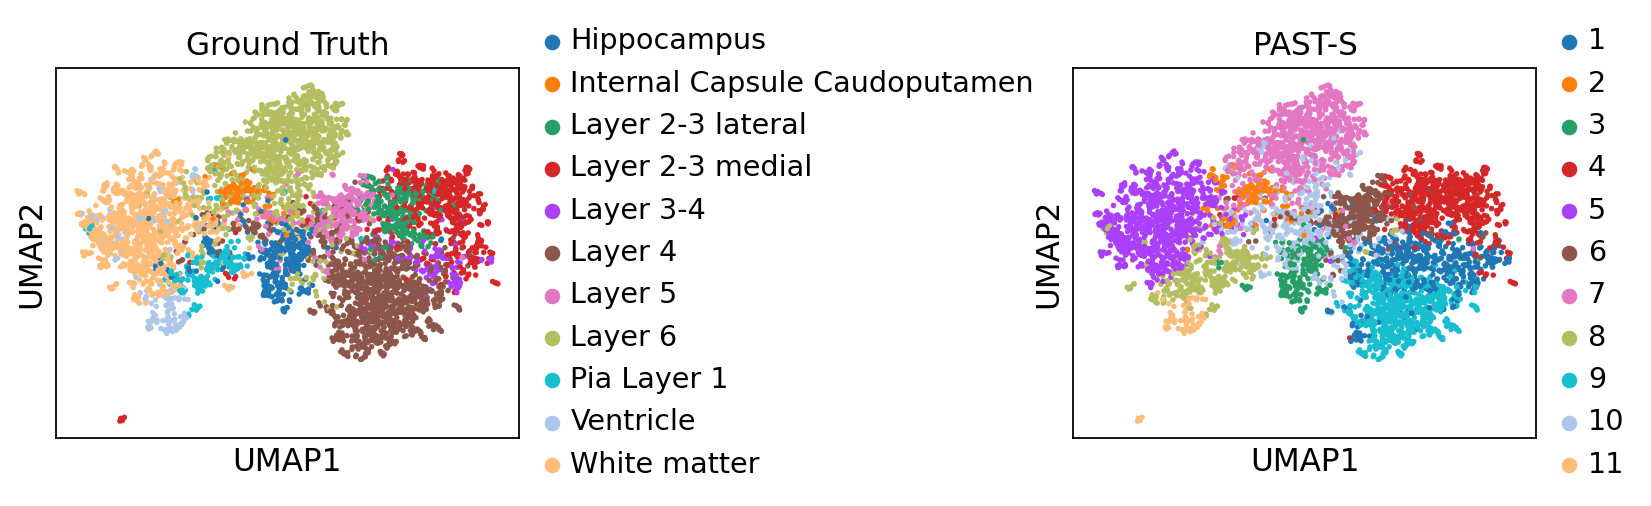

In [12]:
sc.pp.neighbors(sdata, use_rep='embedding')
sc.tl.umap(sdata)
sc.pl.umap(sdata, color=["Region", "mclust"], title=["Ground Truth", "PAST-S"], wspace=1.0)

Visualization of spatial domains colored by ground truth and PAST-derived clusters.

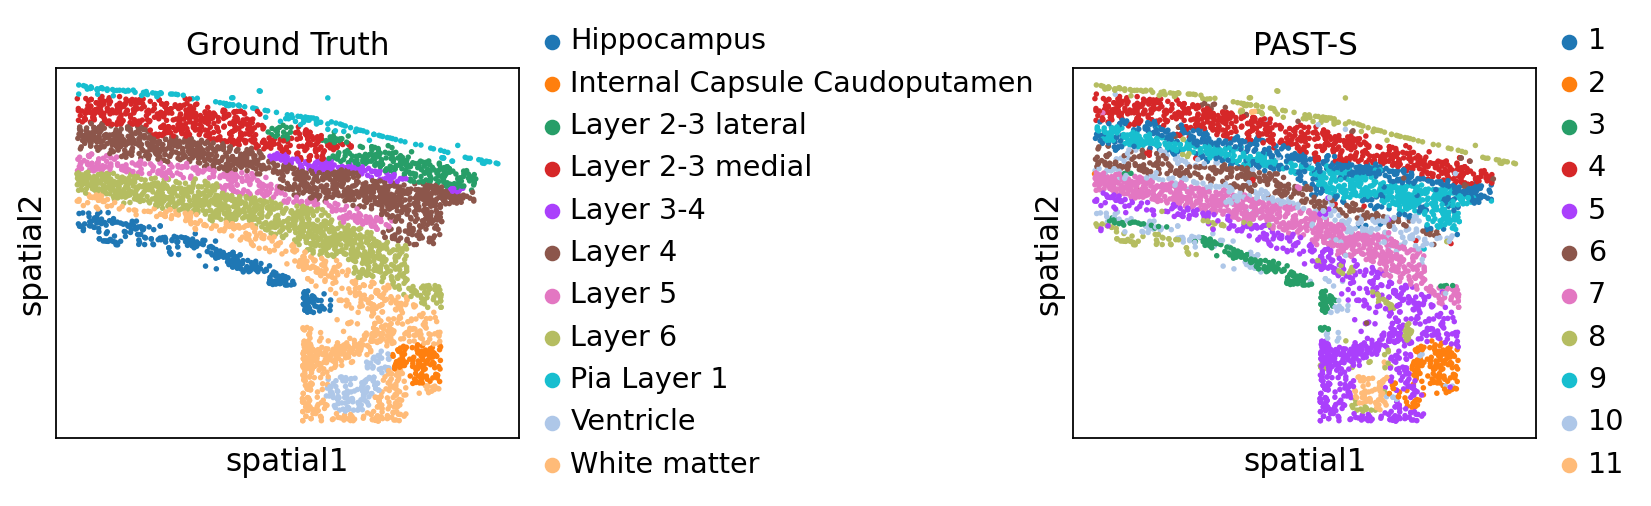

In [13]:
sc.pl.embedding(sdata, color=["Region", "mclust"], basis="spatial", title=["Ground Truth", "PAST-S"], wspace=1.0)